In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import sys
sys.path.append(r'\Users\Mochi\AppData\Local\Programs\Python\Python310\Lib\site-packages')
import quads
import numpy as np

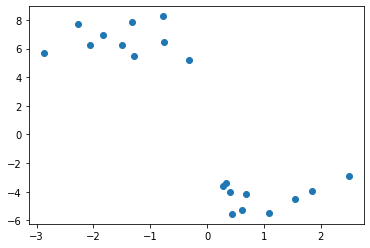

In [59]:
X, y = make_blobs(n_samples=20, centers=2, n_features=2,random_state=100)
plt.scatter(X[:,0], X[:,1])

In [60]:
def find_center(points):
    return np.sum(points, axis=0)/points.shape[0]

In [61]:
def max_distance(points):
    return max(points)-min(points)

In [62]:
center = find_center(X)
center

array([-0.2635916 ,  1.15769532])

In [63]:
wid = max_distance(X[:,0])
hgt = max_distance(X[:,1])
print(wid, hgt)

5.35312773037322 13.808009315922918


In [64]:
tree = quads.QuadTree(
    (center[0],center[1]),  # The center point
    15,  # The width
    15,  # The height
 )
for i in range(X.shape[0]):
    tree.insert(quads.Point(X[i,0], X[i,1]))

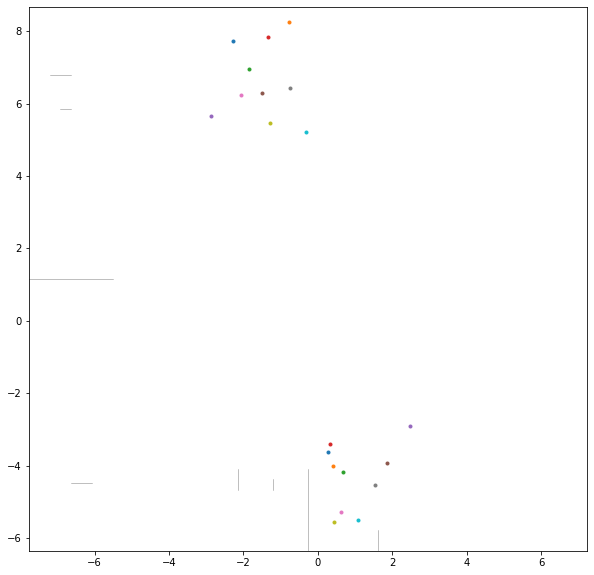

In [65]:
quads.visualize(tree)

In [66]:

def Number_Of_Nodes(node):
    count = 0
    print("node: ", node)
    if node.ul is not None:
        
        if len(node.ul.all_points()) > 0:
                        count+=1
                        ##print("node: ", node)
                        ##print("ul node: ", node.ul)
                        count += Number_Of_Nodes(node.ul)
                        
        if len(node.ur.all_points()) > 0:
                        count+=1
                        ##print("node: ", node)
                        ##print("ur node: ", node.ur)
                        count += Number_Of_Nodes(node.ur)
                        
        if len(node.ll.all_points()) > 0:
                        count+=1
                        ##print("node: ", node)
                        ##print("ll node: ", node.ll)
                        count += Number_Of_Nodes(node.ll)
                        
        if len(node.lr.all_points()) > 0:
                        count+=1
                        ##print("node: ", node)
                        ##print("lr node: ", node.lr)
                        count += Number_Of_Nodes(node.lr)
                          
    return count

In [15]:
def Compute_Diam(node):
    if len(node.all_points()) > 1:
        return node.width
    else:
        return 0   

In [16]:
## referenced at https://stackoverflow.com/questions/12472338/flattening-a-list-recursively
def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

In [20]:
def WSPD(node_u, node_v, epsilon):
    """
    tree : QuadTree type
    
    Returns:
    WSDP_Pair : list of WSDP pairs
    """
    pairs = []
    diam_u = Compute_Diam(node_u)
    diam_v = Compute_Diam(node_v)
    if node_u == node_v and diam_u <=1:
        return []
    if diam_u < diam_v:
        node_u, node_v = node_v, node_u
        diam_u, diam_v = diam_v, diam_u
    if diam_u <= epsilon * Node_Distance(node_u, node_v):
        return (node_u, node_v)
    
    if node_u.ul is not None and len(node_u.ul.all_points()) > 0:
        pairs.append(WSPD(node_u.ul, node_v, epsilon))
    if node_u.ur is not None and len(node_u.ur.all_points()) > 0:
        pairs.append(WSPD(node_u.ur, node_v, epsilon))
    if node_u.ll is not None and len(node_u.ll.all_points()) > 0:
        pairs.append(WSPD(node_u.ll, node_v, epsilon))
    if node_u.lr is not None and len(node_u.lr.all_points()) > 0:
        pairs.append(WSPD(node_u.lr, node_v, epsilon))
        
    pairs =  flatten(pairs)
    pairs = list(set(pairs))
    return pairs

In [18]:
def Node_Distance(node_u, node_v):
    points_u = node_u.all_points()
    points_v = node_v.all_points()
    min_D = sys.float_info.max
    for p_u in points_u:
        for p_v in points_v:
            a = np.array([p_u.x, p_u.y])
            b = np.array([p_v.x, p_v.y])
            if np.linalg.norm(a-b) < min_D:
                min_D = np.linalg.norm(a-b)
    return min_D

In [67]:
wspd = WSPD(tree._root, tree._root, 2)

In [68]:
len(wspd)

21

In [28]:
wspd[0][0].all_points()

[<Point: (-0.5202015420369128, -5.5990529720241575)>,
 <Point: (-0.5019229399608265, -5.29022209324418)>,
 <Point: (1.3039790325473009, -5.915070054491227)>,
 <Point: (0.5887698746701778, -5.772903095908645)>]

In [32]:
import math
e = math.ceil(math.log((1/8), 10) + 1)

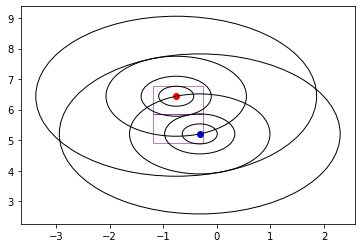

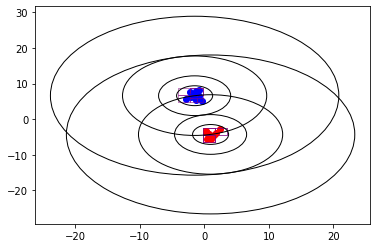

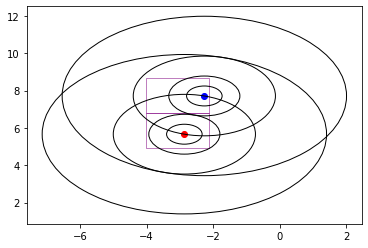

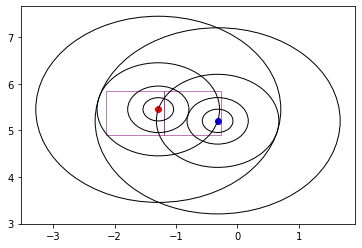

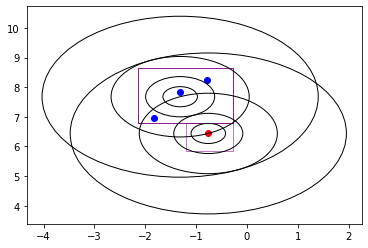

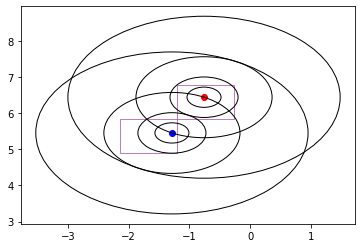

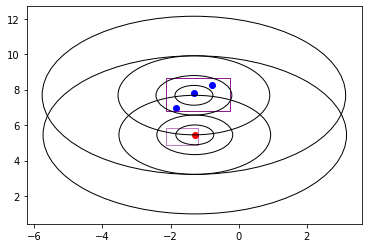

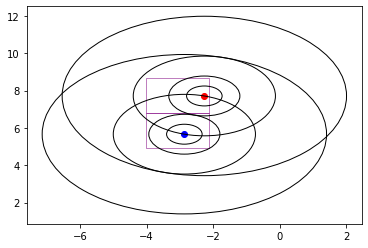

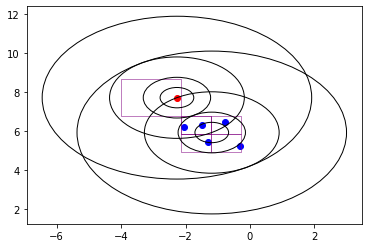

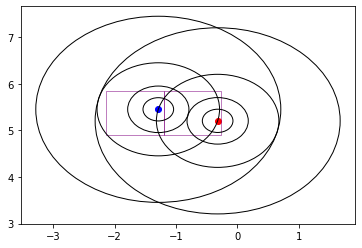

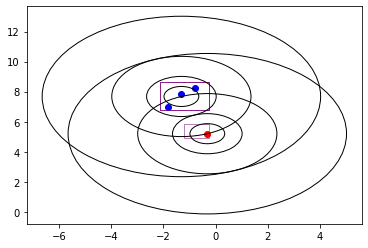

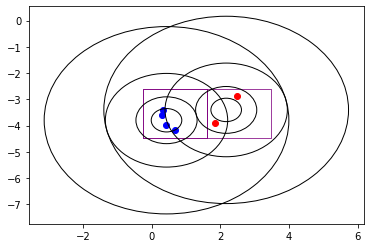

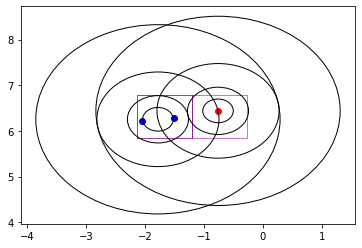

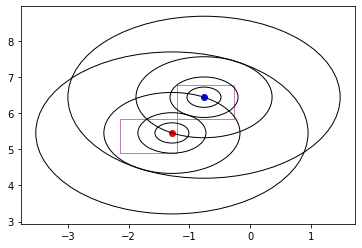

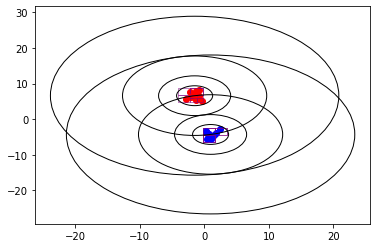

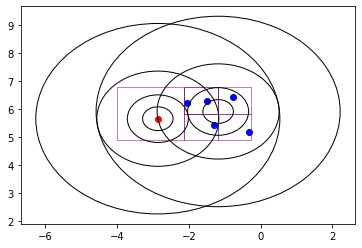

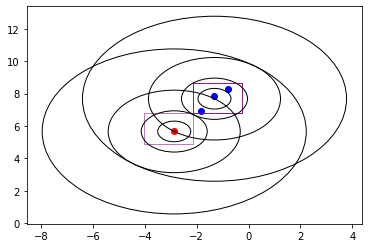

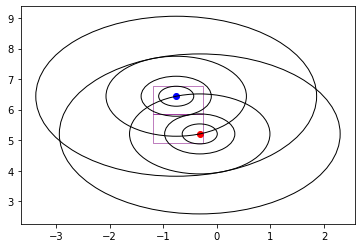

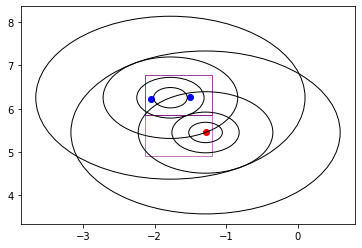

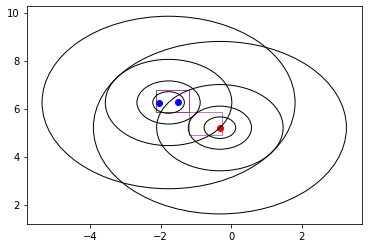

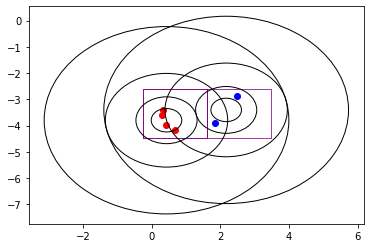

In [69]:
for pair in wspd:
    fig, ax1 = plt.subplots(1, 1)
    u = pair[0].all_points()
    v = pair[1].all_points()
    points_u = []
    points_v = []
    
    for i in range(len(u)):
        points_u.append(np.array([u[i].x, u[i].y]))
        nd, searched_nodes =  tree._root.find_node(u[i])
        ax1.scatter(u[i].x, u[i].y, c='blue');
        rect = patches.Rectangle(((nd.center.x-nd.width/2), (nd.center.y-nd.height/2)), nd.width, nd.height, linewidth=0.5, edgecolor='purple', facecolor='none')
        ax1.add_patch(rect)
    for i in range(len(v)):
        points_v.append(np.array([v[i].x, v[i].y]))
        nd, searched_nodes =  tree._root.find_node(v[i])
        ax1.scatter(v[i].x, v[i].y, c='red');
        rect = patches.Rectangle(((nd.center.x-nd.width/2), (nd.center.y-nd.height/2)), nd.width, nd.height, linewidth=0.5, edgecolor='purple', facecolor='none')
        ax1.add_patch(rect)
    center_u = find_center(np.array(points_u))
    center_v = find_center(np.array(points_v))
    l = np.linalg.norm(center_u- center_v)
    for m in range(-2,e+1):
        circle1 = plt.Circle( (center_u[0], center_u[1] ), pow(2, m)*l, fill = False );
        ax1.add_patch(circle1)
        circle1 = plt.Circle( (center_v[0], center_v[1] ), pow(2, m)*l, fill = False );
        ax1.add_patch(circle1)
    plt.show()

u
(0.3988834186905308, -6.1197989386046325) 1.875 1.875
u
(0.3988834186905308, -6.1197989386046325) 1.875 1.875
u
(0.3988834186905308, -6.1197989386046325) 1.875 1.875
u
(0.3988834186905308, -6.1197989386046325) 1.875 1.875
v
(0.3988834186905308, -4.2447989386046325) 1.875 1.875
v
(0.3988834186905308, -4.2447989386046325) 1.875 1.875


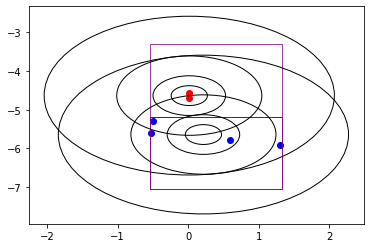

In [54]:
import matplotlib.patches as patches
rad = []
fig, ax1 = plt.subplots(1, 1)
u = wspd[0][0].all_points()
v = wspd[0][1].all_points()
points_u = []
points_v = []
for i in range(len(u)):
    points_u.append(np.array([u[i].x, u[i].y]))
    nd, searched_nodes =  tree._root.find_node(u[i])
    ax1.scatter(u[i].x, u[i].y, c='blue');
    print("u")
    print((nd.center.x, nd.center.y), nd.width, nd.height)
    rect = patches.Rectangle(((nd.center.x-nd.width/2), (nd.center.y-nd.height/2)), nd.width, nd.height, linewidth=0.5, edgecolor='purple', facecolor='none')
    ax1.add_patch(rect)
    # if nd.ul != None:
    #     print("ul")
    #     rect = patches.Rectangle(((nd.ul.center.x-nd.ul.width/2), (nd.ul.center.y-nd.ul.height/2)), nd.ul.width, nd.ul.height, linewidth=0.5, edgecolor='purple', facecolor='none')
    #     ax1.add_patch(rect) 
    # if nd.ur != None:
    #     rect = patches.Rectangle(((nd.ur.center.x-nd.ur.width/2), (nd.ur.center.y-nd.ur.height/2)), nd.ur.width, nd.ur.height, linewidth=0.5, edgecolor='purple', facecolor='none')
    #     ax1.add_patch(rect) 
    # if nd.ll != None:
    #     rect = patches.Rectangle(((nd.ll.center.x-nd.ll.width/2), (nd.ll.center.y-nd.ll.height/2)), nd.ll.width, nd.ll.height, linewidth=0.5, edgecolor='purple', facecolor='none')
    #     ax1.add_patch(rect) 
    # if nd.ul != None:
    #     rect = patches.Rectangle(((nd.lr.center.x-nd.lr.width/2), (nd.lr.center.y-nd.lr.height/2)), nd.lr.width, nd.lr.height, linewidth=0.5, edgecolor='purple', facecolor='none')
    #     ax1.add_patch(rect) 
for i in range(len(v)):
    points_v.append(np.array([v[i].x, v[i].y]))
    nd, searched_nodes =  tree._root.find_node(v[i])
    ax1.scatter(v[i].x, v[i].y, c='red');
    print("v")
    print((nd.center.x, nd.center.y), nd.width, nd.height)
    rect = patches.Rectangle(((nd.center.x-nd.width/2), (nd.center.y-nd.height/2)), nd.width, nd.height, linewidth=0.5, edgecolor='purple', facecolor='none')
    ax1.add_patch(rect)
center_u = find_center(np.array(points_u))
center_v = find_center(np.array(points_v))
l = np.linalg.norm(center_u- center_v)
for m in range(-2,e+1):
    rad.append( pow(2, m)*l)
    circle1 = plt.Circle( (center_u[0], center_u[1] ), pow(2, m)*l, fill = False );
    ax1.add_patch(circle1)
    circle1 = plt.Circle( (center_v[0], center_v[1] ), pow(2, m)*l, fill = False );
    ax1.add_patch(circle1)
plt.show()

In [36]:
wspd[0]

(<QuadNode: (0.3988834186905308, -6.1197989386046325) 1.875x1.875>,
 <QuadNode: (0.3988834186905308, -4.2447989386046325) 1.875x1.875>)

In [38]:
for i in wspd[0][0].all_points():
    nd, searched_nodes =  tree._root.find_node(i)
    print(nd)
    print(searched_nodes)
print("")
for i in wspd[1][0].all_points():
    nd, searched_nodes =  tree._root.find_node(i)
    print(nd)
    print(searched_nodes)

<QuadNode: (0.3988834186905308, -6.1197989386046325) 1.875x1.875>
[<QuadNode: (-2.413616581309469, -3.3072989386046325) 15x15>, <QuadNode: (1.3363834186905308, -7.0572989386046325) 7.5x7.5>, <QuadNode: (-0.5386165813094692, -5.1822989386046325) 3.75x3.75>, <QuadNode: (0.3988834186905308, -6.1197989386046325) 1.875x1.875>]
<QuadNode: (0.3988834186905308, -6.1197989386046325) 1.875x1.875>
[<QuadNode: (-2.413616581309469, -3.3072989386046325) 15x15>, <QuadNode: (1.3363834186905308, -7.0572989386046325) 7.5x7.5>, <QuadNode: (-0.5386165813094692, -5.1822989386046325) 3.75x3.75>, <QuadNode: (0.3988834186905308, -6.1197989386046325) 1.875x1.875>]
<QuadNode: (0.3988834186905308, -6.1197989386046325) 1.875x1.875>
[<QuadNode: (-2.413616581309469, -3.3072989386046325) 15x15>, <QuadNode: (1.3363834186905308, -7.0572989386046325) 7.5x7.5>, <QuadNode: (-0.5386165813094692, -5.1822989386046325) 3.75x3.75>, <QuadNode: (0.3988834186905308, -6.1197989386046325) 1.875x1.875>]
<QuadNode: (0.39888341869053

In [40]:
rad

[0.2570515268003643,
 0.5141030536007286,
 1.0282061072014572,
 2.0564122144029144]

In [42]:
for r in rad:
    print(r/4)

0.06426288170009108
0.12852576340018215
0.2570515268003643
0.5141030536007286


In [72]:
len(wspd[1][0].all_points())

10

In [73]:
len(wspd[1][1].all_points())

10